# Aumento della robustezza della rete

## Abstract
Presento un algoritmo genetico con una codifica specializzata, inizializzazione aleatoria per ottimizzare topologie delle reti di telecomunicazione.Questo problema NP-hard è spesso così
vincolato che un'inizializzazione aleatoria e algoritmi genetici standard generano spesso soluzioni inammissibili. Questa strategia di ottimizzazione può essere usata anche per altri problemi simili.

## Introduzione
Il problema CMST è un'estensione del MST (minimum spanning tree). Un problema che mi chiede di trovare quale struttura
garantisca la connessione fra tutti i nodi con il costo minore. Qui considero un solo flusso d'informazioni (o merci),
cioè single commodity. In generale queste informazioni scorrono su link di capacità finita da un nodo radice a dei nodi
foglia che agiscono da "sink" delle informazioni, i consumatori.
Il problema più spesso risolto nella pratica è quello del MST; dal quale deriviamo il protocollo di rete STP (spanning tree
protocol) di livello link-local (ISO/OSI layer 2). Questa invece è una versione constrained (capacitata) MST.
La formulazione proposta in questo progetto va in una direzione diversa,
sappiamo che nel caso in cui ci sia un server centrale che spinge informazioni lungo la rete il limite di capacità dei link è ricavabile con un probelma di flusso massimo (risolvibile con ad esempio l'algoritmo di Ford&Fulkerson).
* Che dire del caso in cui io abbia decine di nodi collegati al server centrale tramite una dorsale, come valuto la resilienza di una tale rete?
* Come posso garantire che il minor numero di utenti si scolleghi dalla rete nel caso in cui la dorsale si interrompa?
* Per quale tipo di metrica è meglio ottimizzare, la posa in opera dell'infrastruttura o la latenza sulla linea?
* Che dire della ridondanza della rete?

Queste sono solo alcune delle domande che posso includere nel modello come "criteri" guida decisionali. Nel caso in
esame prendo solo in considerazione le prime due domande della lista.

    Vorrei limitare il numero di nodi che sono collegati alla radice attraverso un singolo collegamento (dorsale).

Un primo modo per risolvere è avere un albero "bilanciato", cioè con un numero di nodi circa uguale in ogni ramo della radice. Questo garantisce che, per esempio, se su $ N $ collegamenti uscenti dalla radice se ne interrompesse uno, avrei $ \frac{1}{N} $ utenti scollegati rispetto al totale. Lo stesso ragionamento lo posso ripetere ricorsivamente per ogni sottoalbero che si diparte dalla sorgente. Ciò che vorrei è limitare il numero massimo di utenti serviti da un certo collegamento, in modo da limitare il numero di utenti scollegati in caso di guasti su quello specifico collegamento.

## Formulazione del problema
Una rete di telecomunicazioni può essere modellata da un grafo $ G = (N, A) $ con $ N $ insieme dei nodi che qui rappresenta un cliente che si connette alla rete (telecomunicazioni, gas, in generale è una rete di flusso). L'
insieme $ A $ è l'insieme degli archi che sono attivi e che collegano i nodi nel grafo, in questo caso rappresentano linee attive ed utilizzabili. La rete si ipotizza usi collegamenti bidirezionali e quindi uso un grafo non
orientato. Inoltre ipotizzo che non ci siano archi paralleli (ridondanti), questi in realtà si aggiungono per aumentare il data rate o l'affidabilità. Qui non vengono esaminati, anche se per questo algoritmo non cambia molto.

Impostiamo il seguente programma:

$$ Min \sum_{(i,j) \in A}\ c_{ij} x_{ij} \ $$
$$ \sum_{(j,i) \in A}\ x_{ij} -  \sum_{(i,j) \in A}\ x_{ij} = b_j	 \quad \forall i \in N \qquad (1) \ $$
$$ \sum_{(i,j) \in A}\ y_{ij}  	\leq 1 \quad \forall j \in N 	\setminus{i} \qquad (2) \ $$
$$ \sum_{(i,j) \in S}\ x_{ij}  	\leq |S| - 1 \quad \forall S \in N  \qquad (3) \ $$
$$ x_{ij} \leq  Qy_{ij}  	 \quad \forall (i,j)  \in A \qquad (4)	\ $$
$$ y_{ij} \in \{ 0,1 \}  	 \quad \forall (i,j)  \in A \qquad (5)	\ $$
$$ x_{ij} \geq 0 	 \quad \forall (i,j)  \in A 	\qquad (6) \ $$

$ y_{ij} $ sono le variabili decisionali (creo un collegamento fra $ i $ e $ j $)

$ x_{ij} $ sono le variabili di flusso

Questa variante single commodity del problema MST capacitato può essere modificata per accomodare altri tipi di flusso
i quali non devono mescolarsi o che devono essere in generale sempre distinguibili (eg. traffico di controllo e traffico
utenti) ottenendo la variante multicommodity.

#### Descrizione dei vincoli
* Il vincolo $ (1) $ è il vincolo di conservazione del flusso, che garantisce che ogni utente venga soddisfatto con la sua
richiesta di pacchetti e che i pacchetti non vengano creati o distrutti dal nulla.
* Il vincolo $ (2) $ è il vincolo che mi permette di selezionare un solo arco entrante nel generico nodo $ i-esimo $
* Il vincolo $ (4) $ è il vincolo di linking. Questo è il vincolo complicante, infatti se $ y_{ij} = 0 $ allora non scorre niente; invece se $ y_{ij} = 1 $ il flusso potrebbe non avere più limiti perché posso porre $ Q \to \infty $ (o comunque un big-M). Nel mio caso invece pongo $ Q = n $ con $ n $ un numero opportuno, un upper bound sul numero di nodi serviti da un certo arco. Questo upper bound sarà tanto più stringente quanto più il ramo è vicino alla radice (più sono in alto e più traffico trasporto).
* Il vincolo $ (3) $ è il vincolo di subtour elimination, ogni sottoinsieme di $ k $ nodi deve avere al massimo $ k-1 $ archi. Questo potrebbe essere sostituito da i vincoli di Miller-Tucker-Zemlin che sono in numero polinomiale.

### Complessità
Questo problema a causa dei vincoli di linking è in complessità esponenziale. Questi vincoli legano le variabili
decisionali con quelle di flusso.
Come primo tentativo potrei fare un rilassamento continuo della variabile binaria $ y_{ij} $. Questo però, porterebbe a snaturare il vincolo logico ottenendo $ y_{ij} \geq  \frac{x_{ij}}{Q}$ che per $ Q \to \infty $
che diverrebbe  $ y_{ij} \geq 0 $ e cioè un vincolo inutile.
Oppure posso tentare di rafforzare la formulazione prendendo un $ Q $p leggermente sopra la capacità massima (dunque non un big-M) e sottraendo la richiesta $ b_j $. Attenzione, è possibile costruire un piccolo esempio che dimostra come questo porta a sottostimare i costi della rete.
Costruirsi un rilassamento adeguato non è banale, dunque la prima soluzione euristica che ha dato dei risultati "accettabili" è quella dell'algoritmo genetico di seguito descritto.

### Ipotesi operative
Ora proseguo con le ipotesi operative:
1. La locazione di ogni nodo è già fornita
2. I nodi sono perfettamente affidabili
3. Ogni collegamento è bidirezionale
4. Non ci sono collegamenti ridondanti
5. I collegamenti sono attivi o rotti
6. I fallimenti sono indipendenti fra loro
7. Non vengono esaminate riparazioni
8. La capacità $ Q $ è fissata ad un valore intero

## Algoritmo genetico

Inizializzo con tutti gli import e i parametri interattivi.

In [1]:
import sys
sys.path.append(r"C:\Users\DULLA\PycharmProjects\Thesis_Data_Analisys")
sys.path.append(r"C:\Users\Andi\Desktop\Rebel\Thesis_Data_Analisys")
from random import seed, randint
from time import process_time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from CMST_package.population_generator import draw_graph, generate_population, TREE_LIKE_LAYOUT, breeding_mutation, \
self_mutation, prim, measure_branch

# MODIFICAMI!
NUM_NODES = 10
NUMB_GENER = 300
MESH_LIKE_LAYOUT = 0
HOF_SIZE = 3
MAXIMUM_FITNESS = 1000
POP_SIZE = 100
SELF_MUTATE_PROB = 0.3
CROSS_MUTATE_PROB = 0.7
ROOT = 5
CAPACITY = 4

#img = mpimg.imread('../artifacts/flowchart.PNG')
#plt.figure(figsize=(12, 12))
#plt.axis("off")

#imgplot = plt.imshow(img)

## Matrice di adiacenza aleatoria
Per testare l'algoritmo ho bisogno di avere dei grafi di prova. Questi li posso produrre a partire da dati reali (ad esempio posizioni GPS) oppure posso generarli
sinteticamente. Ho scelto la seconda strada perché più veloce, non devo stare a trovare dati significati e prepararli.

In [2]:
ADJACENCY_MATRIX = [[0 for x in range(NUM_NODES)] for x in range(NUM_NODES)]


def random_adjacency_matrix(matrix):
    """
    Funzione che crea una matrice di adiacenza aleatoria per la simulazione dell'algoritmo. Questa sezione è necessaria
    per testare come si comporta l'algoritmo al variare del grafo, dei pesi o degli archi cioè di chi collego o no.

    QUI IL SEED È PREFISSATO, NON È REALMENTE ALEATORIO, SE LO SI VUOLE ALEATORIO, TOGLIERE IL SEED
    #TODO: la firma è simil-C e fa schifo, restituisci la matrice

    :param matrix: matrice in cui appoggiare i risultati
    :return: matrice del grafo su cui si lavora (da implementare il return)
    """
    global MAXIMUM_FITNESS
    for col in range(len(ADJACENCY_MATRIX)):
        for row in range(col, len(ADJACENCY_MATRIX[col])):
            if col != row:
                value = randint(0, 100)
            else:
                value = sys.maxsize
            ADJACENCY_MATRIX[col][row] = value
            ADJACENCY_MATRIX[row][col] = value

            if row != col:
                if value > MAXIMUM_FITNESS:
                    MAXIMUM_FITNESS = value
                print('{:3}'.format(ADJACENCY_MATRIX[col][row]), end=" ")
                matrix[col][row] = ADJACENCY_MATRIX[col][row]
        print()

# Hall of fame
Questo notebook descrive il modulo deputato a salvare le migliori soluzioni mai viste e a raccoglierle fino alla presentazione finale.

È composto dai seguenti attributi:
> 1. individuals: coda degli individui migliori (vedi l'implementazione dell'[individuo](individual.ipynb))
> 2. size: dimensione della HOF (quante soluzioni considero le migliori)
> 3. paths: lista in cui aggrego tutti gli MST migliori (utile per la visualizzazione)

Essendo l'oggetto Hall of Fame un semplice contenitore delle soluzioni migliori, la sua implementazione è piuttosto semplice. Tutto
ruota attorno alla coda `individuals` e definisco solo le seguenti operazioni:

### Add

In [3]:
import inspect

from CMST_package.hall_of_fame import Hof
lines = inspect.getsource(Hof.add)
print(lines)

    def add(self, individual):
        """
        Aggiungi un nuovo membro alla hall of fame. Ho osservato una nuova soluzione e devo valutare se è il caso di
        immetterlo nella hall of fame. Creo una coda ordinata (in ordine di fitness), inserisco gli individui mai visti
        e quelli vecchi e poiché le dimensioni fra HOF e popolazione potrebbero essere diverse, fintanto che una delle
        due non è vuota continua a immettere gli elementi dalla coda di appoggio alla HOF.

        :type individual: Individual
        :param individual: Individuo da aggiungere nella HOF
        :return:
        """
        temp = q.PriorityQueue()
        while not self.individuals.empty():
            old_ind = self.individuals.get()
            if individual == old_ind:
                continue
            temp.put(old_ind)
        # Se nella coda temporanea non c'è questo individuo allora aggiungi
        temp.put(individual)
        # Finché hai individui a disposizione e posto nella co

Possiamo dire che qui c'è semplicemente un algoritmo che popola una coda con priorità i cui l'ordine è basato sulla fitness. Si distringuono
i casi in cui sia la coda sia vuota (prima inizializzazione) e il caso in cui sia piena (nel ciclo evolutivo).
Per l'implementazione ed una spiegazione dettagliata del codice fare riferimento alla documentazione.

### Update
Questa funzioe è un po' più interessante in quanto qui si vede l'operazione di selezione dei migliori. Questa operazione viene fatta
prendendo la polazione, ordinandola in base alla fitness e poi selezionando (con uno slicing) i primi `size` elementi e infine
questi li rimetto nella coda delle migliori soluzioni.
Con una strutta dati del genere sono sicuro che i primi elementi saranno i migliori, questo torna utile nella visualizzazione finale.

In [4]:
lines = inspect.getsource(Hof.update)
print(lines)

    def update(self, population):
        """
        Aggiorna la hall of fame poiché è cambiata la popolazione a seguito di un ciclo evolutivo. Il procedimento è il
        seguente:
        1. Ordina la popolazione in base alla fitness
        2. Seleziona i migliori individui (i quali stanno in cima alla coda)
        3. Per ognuno di questi individui migliori rimettili nella hall of fame

        :type population: list
        :param population: popolazione su cui valutare la hall of fame
        :return:
        """
        population.sort()
        best_candidates = population[0:self.size]  # Slicing della lista e selezione dei migliori (da 0 a N)
        for individual in best_candidates:
            self.add(individual)



## Codifica

Definisco come soluzione del mio problema una qualunque struttura connessa aciclica che garantisca la copertura di tutti i nodi della rete. Una tale soluzione è un albero ricoprente, quello a cui sono interessato è l'albero
ricoprente di costo minimo soggetto al vincolo di capacità che dovrà essere rispettato per ogni singolo arco.
Poiché con questo algoritmo genetico in uscita avrò un cromosoma (o una rappresentazione equivalente) la soluzione dunque è il cromosoma vincente di fra tutta la popolazione. A questo proposito devo rappresentare:
1. Cosa è un cromosoma
2. Come è fatto un cromosoma

[Savic e Walter](https://doi.org/10.1080/03052150512331303436) hanno usato stringhe di interi a lunghezza variabile per rappresentare una rete di distribuzione idrica.

Consultare il seguente notebook riguardante l'[individuo](individual.ipynb) soluzione e la sua codifica.

# Codifica dell'individuo

Nel rappresentare una soluzione bisogna usare una struttura a grafo, più precisamente uno spanning tree con il costo globalmente minore e che rispetti il vincolo di capacità.

## Descrizione strutture dati

Per fare ciò uso l'oggetto `individual` che rappresenta un individuo della popolazione. Ogni oggetto contiene al suo interno:
- __tree__ che è la lista di tuple che implementa l'albero
- __fitness__ che rappresenta la fitness della soluzione
- __optim_type__ flag che indica se sto minimizzando o massimizzando
- __genotype__ lista di interi a lunghezza variabile che rappresenta la rete

## Aspetti salienti
La scopo principale dell'oggetto `individual` è quello di rappresentarmi la rete in modo maneggiabile. Per farlo creo la rete e la memorizzo nell'attributo _genotype_, così che
ogni individuo sia (all'inizio) una rete completa e poi a fine elaborazione un grafo (sperabilmente) soluzione.
Ogni link possibile gli viene assegnato un intero che segnala la presenza dell'arco. Non solo questo intero segnala la presenza dell'arco ma rappresenta anche il
peso dell'arco stesso nella lista _ordinata_. Ogni lista può definire in modo univoco quali collegamenti esistono e quali no.

Mi appresto a dimostrare la seguente proposizione: la rappresentazione genoma <-> grafo è biunivoca e corretta.
Questa proposizione implica che è possibile partire da una rappresentazione (compatibile con le librerie usate) sotto forma di grafo, ed arrivare ad una
rappresentazione sotto forma di genoma (cioè lista di interi a lunghezza variabile) _e_ _viceversa_.
### dimostrazione

In [5]:
import numpy as np
from CMST_package.individual import Individual
from CMST_package.population_generator import draw_graph
import networkx as nx

Costruisco il grafo assegnando come peso (ed etichetta identificativa) la coppia nodo-sorgente/nodo-destinatario dunque $ C_{ij} = sorgente|destinazione $

In [6]:
G = nx.complete_graph(6)
G[0][1]['weight'] = "01"
G[0][2]['weight'] = "02"
G[0][3]['weight'] = "03"
G[0][4]['weight'] = "04"
G[0][5]['weight'] = "05"
G[1][2]['weight'] = "12"
G[1][3]['weight'] = "13"
G[1][4]['weight'] = "14"
G[1][5]['weight'] = "15"
G[2][3]['weight'] = "23"
G[2][4]['weight'] = "24"
G[2][5]['weight'] = "25"
G[3][4]['weight'] = "34"
G[3][5]['weight'] = "35"
G[4][5]['weight'] = "45"

Creo e visualizzo il grafo full mesh con $ n*(n-1) $ archi, dove $ n $ è il numero di nodi nella rete, in questo caso 6. per cambiare numero nodi, modificare la sezione precedente.

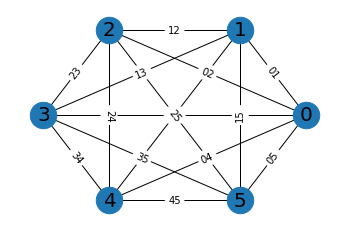

<Figure size 864x864 with 0 Axes>

In [7]:
draw_graph(G, 0)

A questo punto genero la lista di adiacenza in modo da facilitare la conversione in lista normale. Segue poi la visualizzazione della lista di adiacenza.

In [8]:
print("Matrice di adiacenza: ")
adj_list = nx.generate_adjlist(G)

string = ""
i = 0
for arc in adj_list:
    print("Il nodo {0} è connesso con i seguenti nodi: \t{1}".format(i, arc))
    string += arc
    i += 1

Matrice di adiacenza: 
Il nodo 0 è connesso con i seguenti nodi: 	0 1 2 3 4 5
Il nodo 1 è connesso con i seguenti nodi: 	1 2 3 4 5
Il nodo 2 è connesso con i seguenti nodi: 	2 3 4 5
Il nodo 3 è connesso con i seguenti nodi: 	3 4 5
Il nodo 4 è connesso con i seguenti nodi: 	4 5
Il nodo 5 è connesso con i seguenti nodi: 	5


Da notare come la matrice sia triangolare, questo poiché il grafo è _non_ orientato e quindi la lista di adiacenza stampata in forma matriciale non riporta gli
archi in verso opposto. Attenzione alla prima colonna, quelli sono tutti collegamenti loopback, nella matrice di adiacenza sarebbero sulla diagonale. In questo caso
non vengono considerati e in seguito verranno scartati.

Ora proseguo con il mostrare come convertire questa rappresentazione lista-adiacenza in genoma in step successivi:
    1. Reshaping della lista di adiacenza in un vettore 1-d

In [9]:
lista = [item for item in string if item != ' ']
print("La lista srotolata in formato simil-genoma è: \n\t{0}".format(lista))

La lista srotolata in formato simil-genoma è: 
	['0', '1', '2', '3', '4', '5', '1', '2', '3', '4', '5', '2', '3', '4', '5', '3', '4', '5', '4', '5', '5']


    2. A questo punto creo un nuovo individuo di prova e gli assegno la lista di adiacenza srotolata come genoma.

In [10]:
ind = Individual(size=10, min=1, iter_range=256)
ind.genotype = lista
print(ind.genotype)

['0', '1', '2', '3', '4', '5', '1', '2', '3', '4', '5', '2', '3', '4', '5', '3', '4', '5', '4', '5', '5']


Qui vediamo la correttezza dell'operazione in un verso, da grafo l'ho trasformato in genoma.

Adesso il viceversa. Partendo dallo steso individuo voglio, partendo dal suo genoma, ottenere il grafo originario:

    1. Faccio il reshaping del genoma in lista di adiacenza (in forma matriciale), attenzione l'etichetta dell'arco è composta da _sorgente|destinazione|index_

In [11]:
matrix = np.array(ind.reshape2matrix(NUM_NODES=6))
n = matrix.shape[0]
matrix[range(n), range(n)] = "0"
print(matrix)

[['0' '104' '204' '305' '402' '505']
 ['014' '0' '215' '311' '413' '512']
 ['024' '125' '0' '322' '424' '523']
 ['035' '131' '232' '0' '435' '534']
 ['042' '143' '244' '345' '0' '545']
 ['055' '152' '253' '354' '455' '0']]


    2. Creo una nuova matrice dei risultati eliminando la diagonale (in realtà la pongo a zero per problemi di incompatibilità fra librerie)

In [12]:
shape = matrix.shape
result = np.zeros(shape, dtype=int)
for x in range(0, shape[0]):
    for y in range(0, shape[1]):
        result[x, y] = str(matrix[x, y])[0:2]
print(result)

[[ 0 10 20 30 40 50]
 [ 1  0 21 31 41 51]
 [ 2 12  0 32 42 52]
 [ 3 13 23  0 43 53]
 [ 4 14 24 34  0 54]
 [ 5 15 25 35 45  0]]


    3. Visualizzazione del grafo a partire dalla lista di adiacenza, mi aspetto sia lo stesso grafo visualizzato all'inizio.

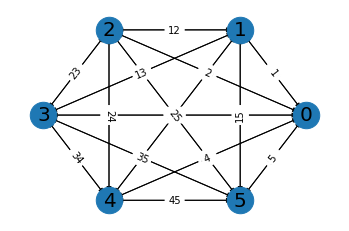

<Figure size 864x864 with 0 Axes>

In [13]:
g = nx.from_numpy_matrix(result, create_using=nx.DiGraph)
draw_graph(g, layout=0)

A meno di alcuni difetti dovuti alla gestione Python delle stringhe, i grafi sono gli stessi. In pratica `01` non è possibile visualizzarlo poiché diventa `1` dato che viene trattato
come un intero e non un'etichetta.

## Reshaping function
Per riarrotolare il genoma dell'individuo devo tenere conto del fatto che il genoma è una versione undimensionale della matrice di adiacenza e che la matrice dei costi è una versione
bidimensionale della lista di adiacenza. Sono entrambe rappresentazioni dei costi ma con forme (dimensioni) diverse. La sezione di codice che esegue l'operazione di riarrotolamento
è la seguente:

```
python
   L = max(row, col)                            # ['0', '1', '2', '3', '4', '5', '1', '2', '3', '4'
   S = min(row, col)                            # 1° step seleziono 0 poi con l'indice L scorro verso
   index = L * (L - 1) / 2                      # destra, ottenendo (0, 1) -> (0,2) e così via
   index += S - 1                               # uso l'indice _index_ come terza cifra per far capire
   index -= L                                   # a che passaggio ero quando ho ricostruito quell'arco
   matrix[col][row] = genome[row]               # sommo (o concateno) i singoli geni del genotipo.
   matrix[col][row] += genome[col]              # nella diagonale avrò sys.maxsize, cioè un peso infinito
   matrix[col][row] += genome[int(index)]       # poiché non voglio archi loopback
```


## Descrizione dell'algoritmo

Per rendere la ricerca efficiente la popolazione iniziale consiste di reti a mesh rappresentate dall'individuo con genoma composto da $ \frac{n*(n-1)}{2}  $ interi.
In sostanza tratto una popolazione come una lista di individui. Per una descrizione delle funzioni usate per l'evoluzione della popolazione
e la fitness dell'individuo consultare il file riguadante la [popolazione](population_generator.ipynb).

> 1. Setup dell'algoritmo

        * Settaggio dei parametri
        * Matrice `ADJACENCY_MATRIX` come matrice iniziale in cui effetturae gli step intermedi (per non sporcare quella buona finale)

> 2. Inizializzazione dell'algoritmo, creo la matrice di adiacenza aleatoria e la visualizzo

 73   4  54  61  73   1  26  59  62 
 35  83  20   4  66  62  41   9 
 31  95  46   5  53  17  77 
 45  48  53  36  86  33 
 58  22  87  38  84 
 46  17  58  98 
 30  56  78 
 48   5 
 74 



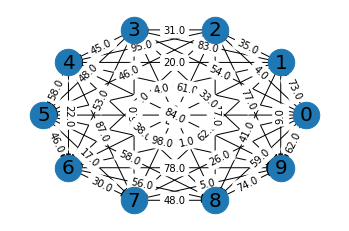

<Figure size 864x864 with 0 Axes>

In [14]:
from CMST_package.hall_of_fame import Hof

seed(10)
Mat = np.zeros((NUM_NODES, NUM_NODES))
random_adjacency_matrix(Mat)
g = nx.from_numpy_matrix(Mat, create_using=nx.DiGraph)
draw_graph(g, MESH_LIKE_LAYOUT)

> 2. Inizializzo la Hall of Fame per memorizzare le migliori soluzioni

In [15]:
hall_of_fame = Hof(HOF_SIZE)

> 3. Genero una popolazione con la quale lanciare l'algoritmo

In [16]:
genome = generate_population(POP_SIZE + (POP_SIZE % 2), int(NUM_NODES * (NUM_NODES + 1) / 2))

> 4. Valutazione della fitness di ogni individuo della popolazione e modifica dei parametri degli individui (riporto il codice per comodità)

In [17]:
def fitness_evaluation(individuals):
    for ind in individuals:
        matrix = ind.reshape2matrix(NUM_NODES)

        # Apply Prim's Algorithm to get Tree
        tree = prim(matrix)

        # Depth first search starting from ROOT
        over_capacity = False
        for edge in tree:
            temp_weight = 0
            if edge[0] == ROOT:
                temp_weight = measure_branch(tree, edge[1], ROOT)
            elif edge[1] == ROOT:
                temp_weight = measure_branch(tree, edge[0], ROOT)
            if temp_weight > CAPACITY:
                ind.tree = tree
                ind.fitness = MAXIMUM_FITNESS
                over_capacity = True

        # Get weight of converted representation if under capacity
        if not over_capacity:
            weight = 0
            for edge in tree:
                (col, row) = edge
                weight += ADJACENCY_MATRIX[col - 1][row - 1]
            ind.tree = tree
            ind.fitness = weight


fitness_evaluation(genome)

> 5. Inizio a popolare la Hall of Fame e visualizzare le migliori soluzioni intermedie

In [18]:
hall_of_fame.update(genome)
print(hall_of_fame)

Fitness: 328
Tree: [(1, 5), (1, 10), (5, 7), (5, 2), (2, 9), (7, 6), (1, 8), (7, 3), (5, 4)]

Fitness: 374
Tree: [(1, 7), (7, 5), (5, 2), (5, 3), (7, 8), (7, 9), (2, 10), (2, 4), (5, 6)]

Fitness: 417
Tree: [(1, 5), (5, 6), (5, 3), (5, 2), (5, 8), (2, 10), (1, 7), (2, 9), (5, 4)]




> 6. Loop evolutivo
        * Mutazione crossover
        * Mutazione singola dalla popolazione in uscita dal crossover
        * Valutazione della fitness
        * Update della Hall of Fame

In [19]:
start = process_time()

for cur_gen in range(NUMB_GENER):
    new_chromosome = breeding_mutation(genome, CROSS_MUTATE_PROB)
    genome = self_mutation(new_chromosome, SELF_MUTATE_PROB)
    fitness_evaluation(genome)
    hall_of_fame.update(genome)

stop = process_time()

> 7. Visualizzazione dei risultati

In [20]:
print(hall_of_fame)
print("Time: ", stop - start)
print("ROOT: ", ROOT)
print("CAPACITY: ", CAPACITY)

Fitness: 335
Tree: [(1, 5), (1, 8), (8, 6), (8, 2), (5, 7), (5, 4), (5, 9), (4, 3), (4, 10)]

Fitness: 391
Tree: [(1, 5), (5, 6), (6, 7), (1, 8), (5, 9), (1, 10), (5, 4), (6, 3), (10, 2)]

Fitness: 419
Tree: [(1, 9), (9, 3), (3, 5), (5, 4), (5, 2), (5, 7), (4, 8), (3, 10), (4, 6)]


Time:  10.4375
ROOT:  5
CAPACITY:  4


> 8. Plot di alcune soluzioni fra le migliori

[(1, 5), (1, 10), (5, 7), (5, 2), (2, 9), (7, 6), (1, 8), (7, 3), (5, 4)]


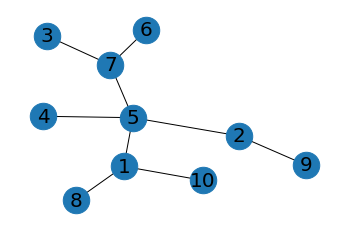

<Figure size 864x864 with 0 Axes>

[(1, 7), (7, 5), (5, 2), (5, 3), (7, 8), (7, 9), (2, 10), (2, 4), (5, 6)]


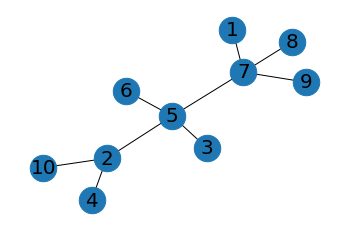

<Figure size 864x864 with 0 Axes>

[(1, 5), (5, 6), (5, 3), (5, 2), (5, 8), (2, 10), (1, 7), (2, 9), (5, 4)]


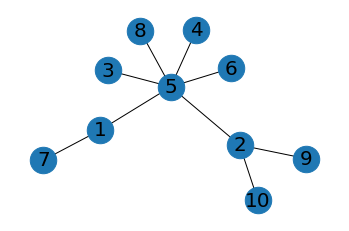

<Figure size 864x864 with 0 Axes>

[(1, 5), (1, 8), (8, 6), (8, 2), (5, 7), (5, 4), (5, 9), (4, 3), (4, 10)]


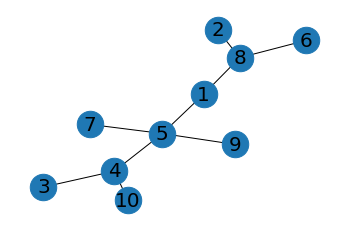

<Figure size 864x864 with 0 Axes>

[(1, 5), (5, 6), (6, 7), (1, 8), (5, 9), (1, 10), (5, 4), (6, 3), (10, 2)]


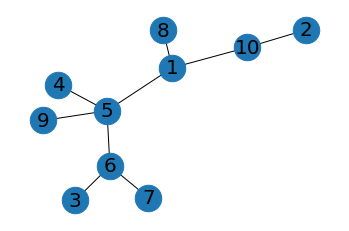

<Figure size 864x864 with 0 Axes>

[(1, 9), (9, 3), (3, 5), (5, 4), (5, 2), (5, 7), (4, 8), (3, 10), (4, 6)]


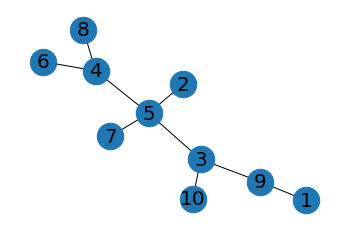

<Figure size 864x864 with 0 Axes>

In [21]:
for candidate in hall_of_fame.paths:
    candidate = [item for item in candidate if item != (0, 0)]
    print(candidate)
    G = nx.Graph()
    G.add_edges_from(candidate)
    draw_graph(G, TREE_LIKE_LAYOUT)

## Conclusioni

Da questi esperimenti eseguiti si vede come la fitness delle varie soluzioni sia piuttosto vicina (in termini percentuali) a quella della miglior soluzione. Ciò vuol dire che se la prima soluzione
è molto buona allora anche le altre saranno un pochino peggio ma comunque usabili. Il problema è quando la miglior soluzione ha una fitness vicino al valore `MAXIMUM_FITNESS`, in tal
caso è molto probabile trovare qualche soluzione che violi i vincoli o che abbia caratteristiche pessime. In molti casi (verificabile lanciando più volte l'algoritmo) si scopre che le
soluzioni con fitness più bassa (e quindi più desiderabili) di solito sono costituite da alberi all'incirca bilanciati. Questo conferma l'intuizione iniziale descritta nella discussione
delle possibili modalità di soluzione tramite rilassamento. Un'ultima nota, questo algoritmo essendo un'euristica fornisce soluzioni che non posso sapere se sono ottime, quindi non
dovrebbero guidare decisioni sensibili/strategiche ma solo fornire un'indicazione di massima.

## Appendice
# Generatore della popolazione

Questo modulo contiene tutte le funzioni necessarie all'algoritmo genetico. Non prevedo un oggetto "problema" con cui agganciare tutti i metodi o gli attributi ma sono
distribuiti nel file.

## Funzione fitness

Definisco la fitness come il costo associato alla soluzione albero nel seguente modo:

$\sum_{(i,j) \in A} c_{ij}x_{ij} + \delta(c_{max}(R(\mathbf{x}) - R_0)^2)$

$ \delta =  \begin{cases}
      0 & R(\mathbf{x}) < R_0 \\
      1 & R(\mathbf{x}) \ge R_0
   \end{cases} $

$ c_{max} = max(c_{ij}) \qquad R_0 $ è il target di capacità massima che voglio per ogni arco

Sia dato un grafo $ G = (N, A) $ e un albero di copertura $T \subset A $. Definiamo la funzione $R(\mathbf{x}) : A \rightarrow \Re $ con $ \mathbf{x} \in T$
vettore di archi, come la funzione di conteggio dei nodi che vengono serviti da un certo arco $ x_{ij} $, gli archi appartengono tutti all'albero $T$ sotto esame.
Questa funzione mi dice qual è il numero totale di nodi che un certo arco sta servendo.

Questa formulazione può essere vista come una formulazione rilassata di quella originale. In particolare ho rilassato con la variabile indicatore il vincolo del
rispetto della capacità. Come descritto sopra ho usato una funzione di accumulazione  $ R(\mathbf{x}) $ e non più la formulazione classica basata su archi.

Poiché nella formulazione originale i vincoli accoppianti erano proprio quelli di capacità e sono sempre questi che rendono il problema NP-hard, è naturale lavorare
principalmente su questo vincoli e poi pensare all'interezza delle variabili (si veda la formulazione nel file [principale](../../notebook/main_pipeline.ipynb)).

Se considerassi $\delta$ come una sorta di moltiplicatore di Lagrange frutto del rilassamento (col quale penalizzo il non rispetto del vincolo $ R(\mathbf{x}) < R_0 $)
allora ha senso inserire il termine $\delta(c_{max}(R(\mathbf{x}) - R_0)^2)$ come penalità nella funzione fitness.

## Funzione di conteggio $R(\mathbf{x})$

Per il conteggio si usa la seguente funzione `measure_branch`, si riporta di seguitio il codice per comodità:

In [22]:
import inspect
from random import random, randint

import networkx as nx
import numpy as np

from CMST_package.individual import Individual
from CMST_package.population_generator import measure_branch, draw_graph, self_mutation

NUM_NODES = 7
CAPACITY = 4
MAXIMUM_FITNESS = 1000
POP_SIZE = 10
TOURNAMENT_SIZE = 2
breeding_mutation_pb = 0.3

lines = inspect.getsource(measure_branch)
print(lines)

def measure_branch(tree, parent, prev):
    """
    Questa funzione conta in modo ricorsivo quanti nodi ci sono in un certo sottoalbero/brach e mi accumula il tutto.

    :param tree:
    :param parent:
    :param prev:
    :return:
    """
    weight = 0
    for edge in tree:
        if edge[0] == parent and edge[1] != prev:
            weight += measure_branch(tree, edge[1], parent)
        elif edge[0] != prev and edge[1] == parent:
            weight += measure_branch(tree, edge[0], parent)
    return weight + 1



La funzione sopra riportata esegue in modo ricorsivo una ricerca simile allo stile breadth-first in modo ricorsivo.
Per ulteriori dettagli si veda la documentazione.

    1. Creo un individuo di test:

In [23]:
matrix = np.zeros((NUM_NODES, NUM_NODES))
ind = Individual(size=int(NUM_NODES * (NUM_NODES + 1) / 2), min=1, iter_range=100)

    2. Rieseguo la procedura per ritornare dal genoma (aleatorio) del mio [individuo](individual.ipynb) test alla matrice di adiacenza (con cui posso lavorare)

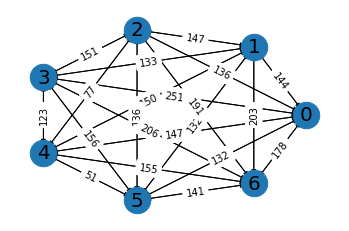

<Figure size 864x864 with 0 Axes>

In [24]:
matrix = np.array(ind.reshape2matrix(NUM_NODES))
n = matrix.shape[0]
matrix[range(n), range(n)] = "0"
shape = matrix.shape
result = np.zeros(shape, dtype=int)
for x in range(0, shape[0]):
    for y in range(0, shape[1]):
        result[x, y] = str(matrix[x, y])[0:2]
g = nx.from_numpy_matrix(matrix, create_using=nx.DiGraph)
draw_graph(g, 0)

    3. Ottengo un MST classico con l'algoritmo di Prim

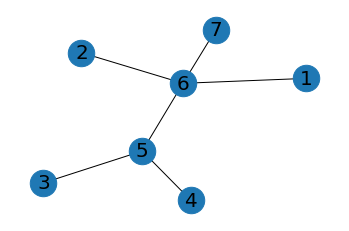

<Figure size 864x864 with 0 Axes>

In [25]:
from CMST_package.population_generator import prim

tree = prim(matrix)
G = nx.Graph()
tree = [arc for arc in tree if arc != (0, 0)]
G.add_edges_from(tree)
draw_graph(G, 1)

    4. Conto i nodi che ci sono in ogni ramo con una procedura breadth-first search, realizzando un primo prototipo della funzione $R(\mathbf{x})$

In [26]:
# Depth first search starting from ROOT
over_capacity = False
ROOT = 1
tree_final = []
for edge in tree:
    temp_weight = 0
    if edge[0] == ROOT:
        temp_weight = measure_branch(tree, edge[1], ROOT)
        print("Dal nodo radice {0} ho {1} nodi".format(ROOT, temp_weight))
    elif edge[1] == ROOT:
        temp_weight = measure_branch(tree, edge[0], ROOT)
        print("Nodi incidenti nella radice----> {0}".format(temp_weight))
    if temp_weight > CAPACITY:
        tree_final = tree
        ind.fitness = MAXIMUM_FITNESS
        over_capacity = True
        print(
            "Violato il vincolo di capacità!! Ho {0} nodi nell'arco {1} arco invece che {2} ".format(temp_weight, edge,
                                                                                                     CAPACITY))
        break

Dal nodo radice 1 ho 6 nodi
Violato il vincolo di capacità!! Ho 6 nodi nell'arco (1, 6) arco invece che 4 


### Osservazioni

Poiché questi genomi sono (per facilitare di test) aleatori, è probabile che si possano incontrare casi in cui un arco sia sovraccarico.
Quando questo accade scatta la guardia situata nell'ultimo `if` e cioè:

```
python
if temp_weight > CAPACITY:
    tree_final = tree
    ind.fitness = MAXIMUM_FITNESS
    over_capacity = True
    print("Violato il vincolo di capacità!! Ho {0} nodi nell'arco {1} arco invece che {2} ".format(temp_weight, edge, CAPACITY))
    break
```

## Calcolo della fitness

__Se__ il numero di nodi rispetta il vincolo di capacità si passa al calcolo del costo effettivo sulla _matrice_ _originale_ $\sum_{(i,j) \in A} c_{ij}x_{ij} $

In [27]:
if not over_capacity:
    weight = 0
    for edge in tree:
        (col, row) = edge
        weight += matrix[col - 1][row - 1]
    ind.tree = tree
    ind.fitness = weight
    print("Costo dell'albero soluzione: {0}".format(weight))
else:
    print("Non ho trovato soluzioni, riprova a lanciare l'algoritmo...")

Non ho trovato soluzioni, riprova a lanciare l'algoritmo...


### Osservazioni
Anche qui bisogna precisare che mi sono allontanato leggermente dalla formulazione originale. Il costo $\sum_{(i,j) \in A} c_{ij}x_{ij} $ è calcolato sulla matrice
originale, cioè quella data in input da ottimizzare, ma se l'individuo sotto esame ha un albero che non rispetta i vincoli di capacità allora gli
viene assegnata una fitness massima (nel codice è uguale a `MAXIMUM_FITNESS`) e viene calcolato il costo comunque. Questo costo, che viene tradotto in
fitness dalle funzioni `fitness_evaluation` e `measure_branch` sarà sopra al valore `MAXIMUM_FITNESS`, rendendo questo individuo inutile.
* Per quale motivo tenere delle soluzioni che violano il vincolo di capacità?
Poiché può succedere che nonostante tutte le iterazioni non riesco a generare un numero sufficiente di soluzioni ammissibili (per vederlo basta allargare la dimensione
Hall of Fame e diminuire le iterazioni e si osservano soluzioni assurde addirittura con cicli...)
* Come mi accorgo di avere una soluzione finale che viola questi vincoli?
Basta osservare la sua fitness, se è pari a `MAXIMUM_FITNESS` allora la soluzione è inammissibile, oppure anche se non del tutto inammissibile (cioé mi accontento
di qualcosa di papabile) questa soluzione sarà pessima. (Invito a provare con varie dimensioni di Hall of Fame e iterazioni nel loop evolutivo).

## Operatore di crossover

La mutazione a coppia implementata qui è un crossover uniforme. Per mostrare come opera questa funzione:

> 1. Creazione di una popolazione iniziale (per l'implementazione del generatore di popolazioni si veda la documentazione)

In [28]:
from CMST_package.population_generator import generate_population

individuals = generate_population(POP_SIZE + (POP_SIZE % 2), int(NUM_NODES * (NUM_NODES + 1) / 2))

> 2. Selezione del gruppo che si accoppierà

In [29]:
group_A = list()
group_B = list()

# Selezione di chi si accoppia Tournament style
mating_group = list()
while len(mating_group) < len(individuals):
    best = None
    for i in range(TOURNAMENT_SIZE):
        # Scegli un individuo a caso
        ind = individuals[randint(0, len(individuals) - 1)]
        # Se l'individuo scelto a caso ha una fitness maggiore -> prendilo
        if best is None or ind.fitness > best.fitness:
            best = ind
    mating_group.append(best)
print("Visualizzazione di un individuo a caso: {0}".format(mating_group[1]))

Visualizzazione di un individuo a caso: 56 51 26 52 185 26 241 135 249 86 121 180 75 221 250 84 112 145 130 210 68 82 42 109 243 137 5 207 


> 3. Estrazione a coppie dei genitori e ripopolazione della "lista padri" e della "lista madri"

In [30]:
while mating_group:
    group_A.append(mating_group.pop())
    group_B.append(mating_group.pop())

> 4. Crossover

In [31]:
ret = list()
for i in range(len(group_A)):
    ind1 = group_A.pop()
    ind2 = group_B.pop()
    if random() < breeding_mutation_pb:
        for i in range(randint(1, len(ind1))):
            # Qui avviene lo scambio
            temp = ind1[i]
            ind1[i] = ind2[i]
            ind2[i] = temp
    ret.append(ind1)
    ret.append(ind2)

## Single Mutation

In modo simile a come fatto per la mutazione a coppia si procede qui nella mutazione del singolo individuo. In pratica seleziono un gene (che qui
sono i costi della lista di adiacenza) e li modifico in modo casuale in modo da cambiare il costo del singolo arco.

In [32]:
lines = inspect.getsource(self_mutation)
print(lines)

def self_mutation(individuals, mutation_pb):
    """
    Self-mutation qui con questa funzione modifico il genotipo del singolo individuo, in pratica è come se gli
    modificassi la matrice equivalente dei costi in modo casuale.
    Potrei modificare un ramo, ma se così facessi otterrei una euristica di scambio (branch exchange heuristic).
    Non seguo questa seconda strada (altrimenti otterrei qualcosa come Esau-Williams) modifico la matrice di adiacenza.

    :param individuals: popolazione da mutare (in pratica un insieme di individui)
    :param mutation_pb: probabilità di mutazione di un gene
    :return:
    """
    for individual in individuals:
        for value in individual:
            if random.random() < mutation_pb:
                value = random.randrange(0, INDEX_RANGE)
    return individuals



Per dettagli e scelte implementative si veda la documentazione delle funzion, oppure il `help()` delle funzioni.